
Sanitized Data Summary:
            price_A         vol_A       price_B          vol_B      price_C  \
count  3367.000000   3367.000000   3367.000000    3367.000000  3367.000000   
mean      1.315086   6653.414656  59974.776253   73998.053550  2227.342008   
std       0.102222  10142.149344   2488.107862  125426.930401   154.604639   
min       1.136350      1.220000  52947.105000       1.852600  1942.845000   
25%       1.214750   2026.534973  57993.845000    1530.915039  2122.535000   
50%       1.299500   3189.639893  60152.315000    8997.179688  2167.635000   
75%       1.415900   5507.334961  62188.030000   96491.503906  2378.455000   
max       1.557050  77046.272500  64760.235000  747358.843750  2544.995000   

               vol_C         lr_A         lr_B         lr_C     dir_next  
count    3367.000000  3367.000000  3367.000000  3367.000000  3367.000000  
mean    27627.924077     0.000024     0.000006     0.000039     0.502822  
std     52078.203930     0.004807     0.002455

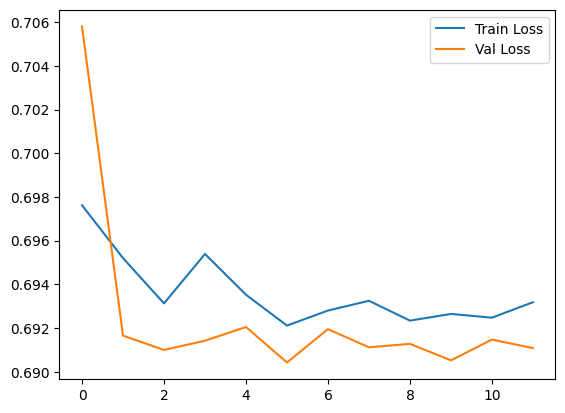

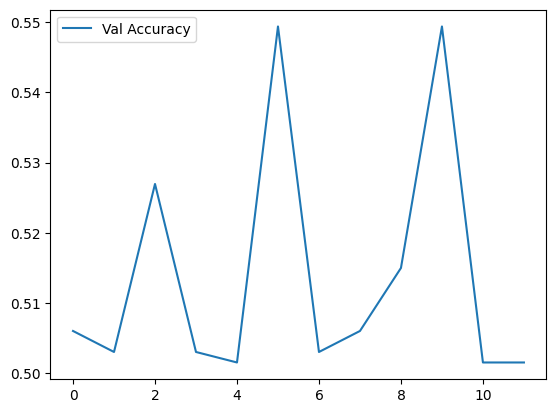

In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
from pathlib import Path



# ============================================================
# 1. Load data
# ============================================================


def load_asset(asset):
    freq = '5min'
    DATA_DIR = Path('../dataset')
    path = DATA_DIR / f"{asset}_{freq}.csv"

    df = pd.read_csv(path)
    df['timestamp'] = pd.to_datetime(df["system_time"])
    df['timestamp'] = df['timestamp'].dt.round('min')
    df = df.sort_values('timestamp').set_index('timestamp')
    return df[['midpoint','bids_notional_0']]  
    
df_ADA = load_asset("ADA").rename(columns={'midpoint': 'ADA', 'bids_notional_0': 'vol_ADA'})
df_BTC = load_asset("BTC").rename(columns={'midpoint': 'BTC', 'bids_notional_0': 'vol_BTC'})
df_ETH = load_asset("ETH").rename(columns={'midpoint': 'ETH', 'bids_notional_0': 'vol_ETH'})
df = df_ADA.join(df_BTC).join(df_ETH)

df.rename(columns={'ADA': 'price_A', 'vol_ADA': 'vol_A', 'BTC': 'price_B', 'vol_BTC': 'vol_B', 'ETH': 'price_C', 'vol_ETH': 'vol_C'}, inplace=True)
df.reset_index(inplace=True)

T = len(df)

# log returns & target
df["lr_A"] = np.log(df["price_A"]).diff().fillna(0)
df["lr_B"] = np.log(df["price_B"]).diff().fillna(0)
df["lr_C"] = np.log(df["price_C"]).diff().fillna(0)
df["dir_next"] = (df["price_B"].shift(-1) > df["price_B"]).astype(int)

# ============================================================
# 2. Full cleaning pipeline
# ============================================================

for col in ["vol_A", "vol_B", "vol_C"]:
    df[col] = df[col].clip(lower=1e-6)

def winsorize(series, q=0.995):
    low = series.quantile(1-q)
    high = series.quantile(q)
    return series.clip(lower=low, upper=high)

for col in ["vol_A", "vol_B", "vol_C"]:
    df[col] = winsorize(df[col])

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.ffill(inplace=True)
df.bfill(inplace=True)

for col in ["price_A", "price_B", "price_C"]:
    df[col] = df[col].clip(lower=1e-8)

df["lr_A"] = np.log(df["price_A"]).diff().fillna(0)
df["lr_B"] = np.log(df["price_B"]).diff().fillna(0)
df["lr_C"] = np.log(df["price_C"]).diff().fillna(0)

for col in ["lr_A", "lr_B", "lr_C"]:
    df[col] = df[col].clip(lower=-0.2, upper=0.2)

print("\nSanitized Data Summary:\n", df.describe())


# ============================================================
# 3. Multi-window correlations
# ============================================================

candidate_windows = [6, 12, 24, 48, 96]
n_w = len(candidate_windows)

edges = [("A", "B"), ("A", "C"), ("C", "B")]
n_edges = len(edges)

corr_array = np.zeros((T, n_edges, n_w), dtype=np.float32)

for wi, w in enumerate(candidate_windows):
    r_ab = df["lr_A"].rolling(w, min_periods=1).corr(df["lr_B"]).fillna(0)
    r_ac = df["lr_A"].rolling(w, min_periods=1).corr(df["lr_C"]).fillna(0)
    r_cb = df["lr_C"].rolling(w, min_periods=1).corr(df["lr_B"]).fillna(0)

    corr_array[:, 0, wi] = np.nan_to_num(r_ab)
    corr_array[:, 1, wi] = np.nan_to_num(r_ac)
    corr_array[:, 2, wi] = np.nan_to_num(r_cb)

print("corr_array shape:", corr_array.shape)

# ============================================================
# 4. Dataset
# ============================================================

class MarketDataset(Dataset):
    def __init__(self, df, corr_array, window=24):
        self.df = df.reset_index(drop=True)
        self.corr_array = corr_array
        self.window = window
        self.T = len(df)

        P = df[["price_A","price_B","price_C"]].values
        V = np.log1p(df[["vol_A","vol_B","vol_C"]].values)

        self.p_mean = P.mean(0)
        self.p_std  = P.std(0) + 1e-6
        self.v_mean = V.mean(0)
        self.v_std  = V.std(0) + 1e-6

    def __len__(self):
        return self.T - self.window - 2

    def __getitem__(self, idx):
        X = []
        for t in range(idx, idx+self.window):
            r = self.df.iloc[t]

            p = np.array([r.price_A,r.price_B,r.price_C],dtype=np.float32)
            v = np.log1p(np.array([r.vol_A,r.vol_B,r.vol_C],dtype=np.float32))

            p = (p - self.p_mean)/self.p_std
            v = (v - self.v_mean)/self.v_std

            X.append(np.stack([p,v],axis=1))

        y = int(self.df.iloc[idx+self.window].dir_next)
        corr_slice = self.corr_array[idx:idx+self.window,:,:]

        return torch.tensor(X,dtype=torch.float32), \
               torch.tensor(y), \
               torch.tensor(corr_slice,dtype=torch.float32)


window = 24
full_ds = MarketDataset(df, corr_array, window)

N = len(full_ds)
i_train = int(0.5*N)
i_val   = int(0.7*N)

train_ds = torch.utils.data.Subset(full_ds,range(0,i_train))
val_ds   = torch.utils.data.Subset(full_ds,range(i_train,i_val))
test_ds  = torch.utils.data.Subset(full_ds,range(i_val,N))

train_loader = DataLoader(train_ds,batch_size=32,shuffle=True)
val_loader   = DataLoader(val_ds,batch_size=32)
test_loader  = DataLoader(test_ds,batch_size=32)

print(len(train_ds), len(val_ds), len(test_ds))


# ============================================================
# 5. Multi-Block A3TGCN
# ============================================================

class A3TGCNBlock(nn.Module):
    def __init__(self, in_feat, hidden):
        super().__init__()
        self.gcn = nn.Linear(in_feat, hidden)
        self.att = nn.MultiheadAttention(embed_dim=hidden, num_heads=4, batch_first=True)

    def forward(self, X, A):
        H = self.gcn(X)
        A_norm = A / (A.sum(-1, keepdims=True)+1e-6)
        H = torch.bmm(A_norm, H)
        H2, _ = self.att(H,H,H)
        return H + H2


class A3TGCN_Multi(nn.Module):
    def __init__(self, hidden=64, n_w=5, n_blocks=4):
        super().__init__()
        self.n_blocks = n_blocks

        self.w_att = nn.Parameter(torch.randn(3,n_w))

        blocks = []
        blocks.append(A3TGCNBlock(in_feat=2, hidden=hidden))
        for _ in range(n_blocks-1):
            blocks.append(A3TGCNBlock(in_feat=hidden, hidden=hidden))

        self.blocks = nn.ModuleList(blocks)
        self.fc = nn.Linear(hidden,2)

    def build_adj(self, e):
        ab = e[:,0]
        ac = e[:,1]
        bc = e[:,2]

        B = e.size(0)
        A = torch.zeros(B,3,3,device=e.device)

        A[:,0,1]=A[:,1,0]=ab
        A[:,0,2]=A[:,2,0]=ac
        A[:,1,2]=A[:,2,1]=bc
        A[:,range(3),range(3)] = 1.0
        return A

    def forward(self, X, corr_slice):
        B,T,_,_ = X.shape

        w = F.softmax(self.w_att,dim=-1)
        edges = torch.einsum("bt e w, e w -> b t e", corr_slice, w)
        e_last = edges[:, -1, :]

        A = self.build_adj(e_last)
        X_last = X[:, -1, :, :]

        H = X_last
        for block in self.blocks:
            H = block(H, A)

        logits = self.fc(H.mean(1))
        return logits, w


# ============================================================
# 6. Training
# ============================================================

device = "cuda" if torch.cuda.is_available() else "cpu"
model = A3TGCN_Multi(hidden=64, n_w=n_w, n_blocks=4).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loss_hist = []
val_loss_hist = []
val_acc_hist = []

epochs = 12

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for X,y,corr in train_loader:
        X,y,corr = X.to(device),y.to(device),corr.to(device)

        optimizer.zero_grad()
        logits,_ = model(X,corr)
        loss = criterion(logits,y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    train_loss_hist.append(total_loss/len(train_loader))

    model.eval()
    total, correct, val_loss = 0,0,0
    with torch.no_grad():
        for X,y,corr in val_loader:
            X,y,corr = X.to(device),y.to(device),corr.to(device)
            logits,_ = model(X,corr)
            loss = criterion(logits,y)
            val_loss += loss.item()
            pred = logits.argmax(1)
            correct += (pred==y).sum().item()
            total += y.size(0)

    val_loss_hist.append(val_loss/len(val_loader))
    val_acc = correct/total
    val_acc_hist.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} | TrainLoss={train_loss_hist[-1]:.4f} | "
          f"ValLoss={val_loss_hist[-1]:.4f} | ValAcc={val_acc:.4f}")


# ============================================================
# 7. Test
# ============================================================

model.eval()
correct,total = 0,0
with torch.no_grad():
    for X,y,corr in test_loader:
        X,y,corr = X.to(device),y.to(device),corr.to(device)
        logits,_ = model(X,corr)
        pred = logits.argmax(1)
        correct += (pred==y).sum().item()
        total += y.size(0)

print("\nFinal Test Accuracy:", correct/total)


# ============================================================
# 8. Plots
# ============================================================

plt.plot(train_loss_hist,label="Train Loss")
plt.plot(val_loss_hist,label="Val Loss")
plt.legend()
plt.show()

plt.plot(val_acc_hist,label="Val Accuracy")
plt.legend()
plt.show()
